<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_Deep_Learning_Con_TernsorFlow_Machine-Learning_e_IA-/blob/master/scripts/tema07/05-low-birth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#pip install tensorflow==1.14

# Red neuronal multicapa para predecir el bajo peso de un recién nacido

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import numpy as np

In [0]:
session = tf.Session()

In [0]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat?token=AMRAeLOMrOCZKT3UgcdcA3VC4ep-4pYNks5cb-CGwA%3D%3D"
birth_file = requests.get(url)
birth_data = birth_file.text.split('\r\n')
birth_header = birth_data[0].split('\t')# fila 0 como Cabezera
birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]

In [7]:
birth_header

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']

In [0]:
y_vals = np.array([x[8] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

In [0]:
seed = 2019
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 100

In [0]:
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

In [30]:
print(train_idx)
print(test_idx)

[156 168  10 172  36  61 109  48  69 121  95  38 150  42  34 123 164   0
 163 181  81  20  18  47   7  94  88   6 173  62  74  35  19  25  33 167
 132  43  46 177 101 146 144 118  75 105 185 124  14 122 141 127  84  76
  40 110 155  53  50 171  99  56  77  85  44   9 165  55  64  51  39 188
  41  68 157  67  27  13  66 160 134 139 148 153  30 152   1 111   4 186
   5 180 107 154 169 137 151  23 142  73 149 179  31  87 174  52  60 100
 103 129  32 125 117  93 108  59   2 178  63 158 147 175 126 120 113 128
  45  49  17  78 182 183 130  22  92 104 166  89  90  98  91  57 162 131
 187   8 102  79 112 145  26]
[  3 133 135 136 138  11  12 140  15  16 143  21  24  28  29 159 161  37
 170 176  54 184  58  65  70  71  72  80  82  83  86  96  97 106 114 115
 116 119]


In [0]:
x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]
y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

In [0]:
def normalize_cols(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return(m-col_min)/(col_max-col_min), col_min, col_max

In [0]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))# normalizamos 
x_vals_test,_,_ = np.nan_to_num(normalize_cols(x_vals_test, train_min, train_max))

In [0]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape = shape, stddev=st_dev))
    return weight

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape = shape, stddev=st_dev))
    return bias

In [0]:
x_data = tf.placeholder(shape=[None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [0]:
def full_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(layer)

- Dato de entrada: 7 -> capa oculta 1: 25, la capa tiene 7 * 25 + 25 = 200 variables
- Capa oculta 1: 25 -> capa oculta 2: 10, la capa tiene 25 * 10 + 10 = 260 variables
- Capa oculta 2: 10 -> capa oculta 3: 3, la capa tiene 10 * 3 + 3 = 33 variables
- Capa oculta 3: 3 -> Capa de Salida: 1, la capa tiene 3 * 1 + 1 = 4 variables

En total la red neuronal tiene que estimar 200+260+33+4 = 497 variables

In [0]:
w1 = init_weight(shape=[7,25], st_dev=10.0)
b1 = init_bias(shape=[25], st_dev=10.0)
layer1 = full_connected(x_data, w1, b1) 

w2 = init_weight(shape=[25,10], st_dev=10.0)
b2 = init_bias(shape=[10], st_dev=10.0)
layer2 = full_connected(layer1, w2, b2)

w3 = init_weight(shape=[10,3], st_dev=10.0)
b3 = init_bias(shape=[3], st_dev=10.0)
layer3 = full_connected(layer2, w3, b3)

w4 = init_weight(shape=[3,1], st_dev=10.0)
b4 = init_bias(shape=[1], st_dev=10.0)
layer4 = full_connected(layer3, w4, b4) 

In [0]:
loss = tf.reduce_mean(tf.abs(y_target-layer4))# las medias de las diferencias de los valores absolutos
my_optim = tf.train.AdamOptimizer(0.05)
train_step = my_optim.minimize(loss)
init = tf.global_variables_initializer()
session.run(init)

In [39]:
loss_vects = []
test_loss = []
for i in range(300):
    rand_idx = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vects.append(temp_loss)
    
    test_temp_loss = session.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    
    if(i+1)%25==0:
        print("Paso #"+str(i+1)+", Loss = "+str(temp_loss))

Paso #25, Loss = 49760.55
Paso #50, Loss = 16945.85
Paso #75, Loss = 6456.4575
Paso #100, Loss = 5520.7886
Paso #125, Loss = 9753.916
Paso #150, Loss = 2102.1487
Paso #175, Loss = 3389.3704
Paso #200, Loss = 2233.0432
Paso #225, Loss = 2013.4019
Paso #250, Loss = 951.7566
Paso #275, Loss = 911.36053
Paso #300, Loss = 1585.0056


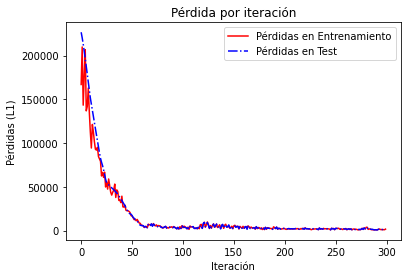

In [40]:
plt.plot(loss_vects, 'r-', label="Pérdidas en Entrenamiento")
plt.plot(test_loss, 'b-.', label="Pérdidas en Test")
plt.title("Pérdida por iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdidas (L1)")
plt.legend(loc="upper right")
plt.show()

In [0]:
actuals = np.array([x[0] for x in birth_data])
test_actuals = actuals[test_idx]
train_actuals = actuals[train_idx]
test_pred = [x[0] for x in session.run(layer4, feed_dict={x_data:x_vals_test})]
train_pred = [x[0] for x in session.run(layer4, feed_dict={x_data:x_vals_train})]
test_pred = np.array([1.0 if x<2500.0 else 0.0 for x in test_pred])
train_pred = np.array([1.0 if x<2500.0 else 0.0 for x in train_pred])

In [0]:
test_acc = np.mean([x==y for x,y in zip(test_pred, test_actuals)])
train_acc = np.mean([x==y for x,y in zip(train_pred, train_actuals)])

In [47]:
test_acc

0.6578947368421053

In [48]:
train_acc

0.6887417218543046